## TIMON demo on human fetal microglia project
##### Author: Rick Z Li

The object of this demo is to identify co-occurring transcription factor pairs,
    and through permutation with the random genomic background, identify 
    significant co-occurring relationship to construct co-occurrence networks.


- **[Compute co-occurrence between transcription factors ](#preprocess)**
    - optional: compute gc array to use gc matched peaks
    - optional: perform analysis with only expressed transcription factors ( with expressed TFs list)


- **[Compute significant edges](#sig_edge)**
    - use monte carlo permutation to compute significant edges p<0.01




- **[Plot Networks using Networkx](#network)**

    - fetal network
    - fetal network with highlighted TFs
    - pn network
    - pn network with highted TFs
    

In [1]:
# load data structure packages
import numpy as np
import pandas as pd
import sys
import re
import os
from TIMON.motifFreq import readFasta,sigEdges,calcGC,motifFreq,motifFreq_overlap, uniqueTF
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx

<a id="preprocess"></a>
## run co-occurrence analysis

#### load expressed tf list

In [2]:
exp_bool_df=pd.read_csv("./data/fetal_pn_mg_expressed_bool_df.csv")
pn_expressed_tf_bool = list(exp_bool_df.iloc[:,2])
fetal_expressed_tf_bool = list(exp_bool_df.iloc[:,1])
tfnames=np.array( exp_bool_df.iloc[:,0]) 

#### run non-overlapping motif co-occurrence count

In [4]:
fetal_enhancer_path="./fetal_only_enhancer15_300bp.fa"
fetal_obj=motifFreq(fetal_enhancer_path,ncore=40,subset_factor=1)
fetal_motif_mtx=fetal_obj.allPeaksMotifsScore()

fetal_gc_obj=calcGC(fetal_enhancer_path,subset_factor=1)
fetal_gc_array=fetal_gc_obj.computeGC()

fetal_edges_obj=sigEdges(fetal_motif_mtx,fetal_gc_array,bg_path='bg_all_one_hot_all.npy',n_iter=10000,gc_match=True)
plist_fetal= fetal_edges_obj.runEdge()

pn_enhancer_path="pn_only_enhancer15_300bp.fa"
pn_obj=motifFreq(pn_enhancer_path,ncore=40,subset_factor=1)
pn_motif_mtx=pn_obj.allPeaksMotifsScore()

pn_gc_obj=calcGC(pn_enhancer_path,subset_factor=1)
pn_gc_array=pn_gc_obj.computeGC()

pn_edges_obj=sigEdges(pn_motif_mtx,pn_gc_array,bg_path='bg_all_one_hot_all.npy',n_iter=10000,gc_match=True)
plist_pn= pn_edges_obj.runEdge()


<a id="sig_edge"></a>
## Identify significant edges (p<0.01)

In [5]:
fetal_expressed_tf_bool=np.array(fetal_expressed_tf_bool)
pn_expressed_tf_bool=np.array(pn_expressed_tf_bool)
tfpairs= list(combinations(range(len(tfnames)),2))
fetal_expressed_idx= np.where(fetal_expressed_tf_bool==True)[0]
pn_expressed_idx= np.where(pn_expressed_tf_bool==True)[0]

tfpairs_np=np.array(tfpairs)
fetal_both_expressed_bool = np.array([True if ((bool(np.isin(pair[0] ,fetal_expressed_idx))) & (bool(np.isin(pair[1] ,fetal_expressed_idx)))) else False for pair in tfpairs] )
pn_both_expressed_bool = np.array([True if ((bool(np.isin(pair[0] ,pn_expressed_idx))) & (bool(np.isin(pair[1] ,pn_expressed_idx)))) else False for pair in tfpairs])

fetal_sig_edge= plist_fetal > 99.5
pn_sig_edge= plist_pn > 99.5

fetal_bool = np.multiply(fetal_both_expressed_bool, fetal_sig_edge)
pn_bool = np.multiply(pn_both_expressed_bool, pn_sig_edge)

fetal_pairs= tfpairs_np[fetal_bool]
pn_pairs= tfpairs_np[pn_bool]

fetal_pair_tf_name=[(tfnames[pair[0]], tfnames[pair[1]]) for pair in fetal_pairs]
pn_pair_tf_name=[(tfnames[pair[0]], tfnames[pair[1]])for pair in pn_pairs]

fetal_unique_pairs=[pair for pair in fetal_pair_tf_name if ((pair in pn_pair_tf_name) ==False )  ]
pn_unique_pairs=[pair for pair in pn_pair_tf_name if ((pair in fetal_pair_tf_name) ==False )  ]

<a id="network"></a>
## plot co-occurrence network using networkx

#### fetal network

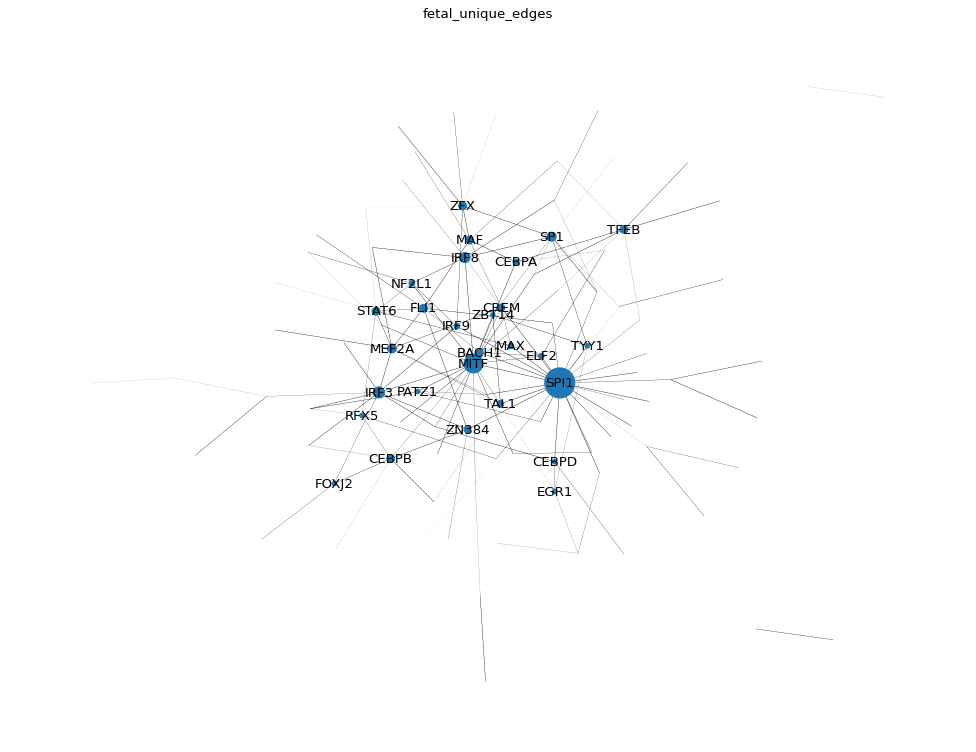

In [7]:
plt.figure(figsize=(12, 9), dpi=80)
G_fetal_unq=nx.from_edgelist(fetal_unique_pairs)
edges = G_fetal_unq.edges()
weights = [ 2* (100-plist_fetal[tfpairs.index(tuple(sorted((list(tfnames).index(u),list(tfnames).index(v)))))]) /100  for u,v in edges ]
weights_log= [((weight - 0.01 ) / (0-0.01)) /3 for weight in weights]
G_fetal_unq=nx.from_edgelist(fetal_unique_pairs)
pos_fetal_unq = nx.nx_agraph.pygraphviz_layout(G_fetal_unq)
d = dict(G_fetal_unq.degree)
label_dict={}
for k,v in zip(G_fetal_unq.nodes,G_fetal_unq.nodes):
    if d[v]>3:  # only show labels for node degree >3
        label_dict[k]=v
    else:
        label_dict[k]=""
nx.draw(G_fetal_unq,pos=pos_fetal_unq,with_labels=False, node_size=[v*v if v>3 else 0 for v in d.values() ],width=weights_log )
nx.draw_networkx_labels(G_fetal_unq,pos_fetal_unq,label_dict)

plt.title("fetal_unique_edges")
plt.show()

#### demo to highlight selected TFs, fetal

In [8]:
tfs_to_highlight_fetal=['SPI1', 'MITF', 'ELF2']

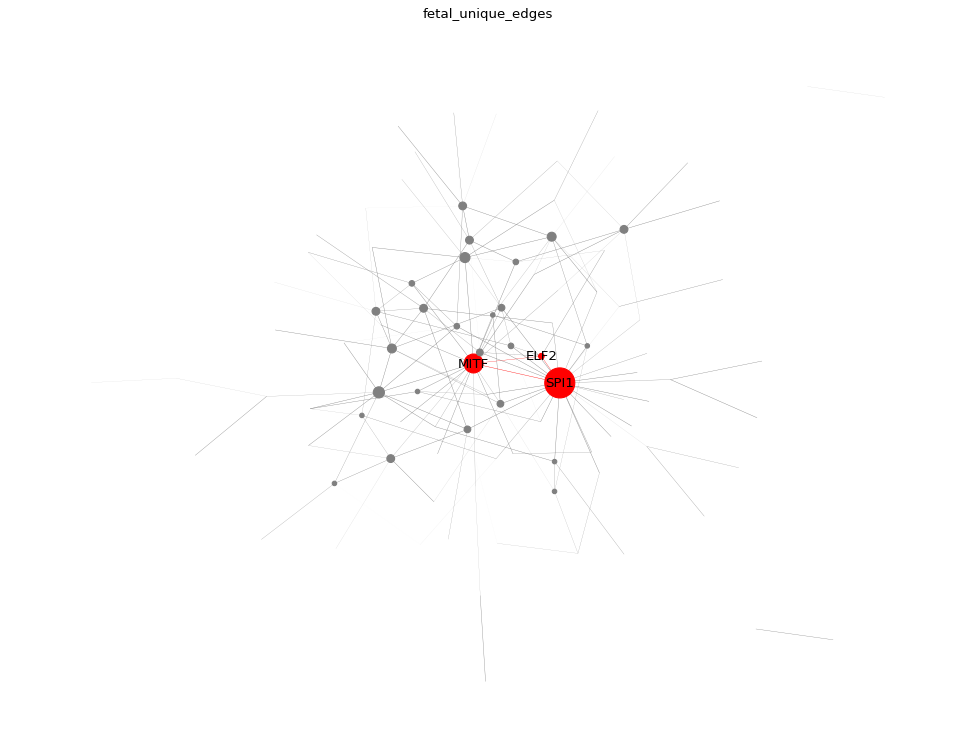

In [14]:
color_map = ['red' if node in tfs_to_highlight_fetal else 'grey' for node in G_fetal_unq]        
plt.figure(figsize=(12, 9), dpi=80)
edges = G_fetal_unq.edges()
weights = [ 2* (100-plist_fetal[tfpairs.index(tuple(sorted((list(tfnames).index(u),list(tfnames).index(v)))))]) /100  for u,v in edges ]
weights_log= [((weight - 0.01 ) / (0-0.01)) /3 for weight in weights]
G_fetal_unq=nx.from_edgelist(fetal_unique_pairs)
edge_colors = ["red" if (u in tfs_to_highlight_fetal) & (v in tfs_to_highlight_fetal) else "grey"  for u,v in edges]

d = dict(G_fetal_unq.degree)
label_dict={}
for k,v in zip(G_fetal_unq.nodes,G_fetal_unq.nodes):
    if v in tfs_to_highlight_fetal:
        label_dict[k]=v
    else:
        label_dict[k]=""
nx.draw(G_fetal_unq,pos=pos_fetal_unq,with_labels=False,edge_color=edge_colors,node_color=color_map, node_size=[v*v if v>3 else 0 for v in d.values() ],width=weights_log )
nx.draw_networkx_labels(G_fetal_unq,pos_fetal_unq,label_dict)

plt.title("fetal_unique_edges")
plt.show()

#### pn network

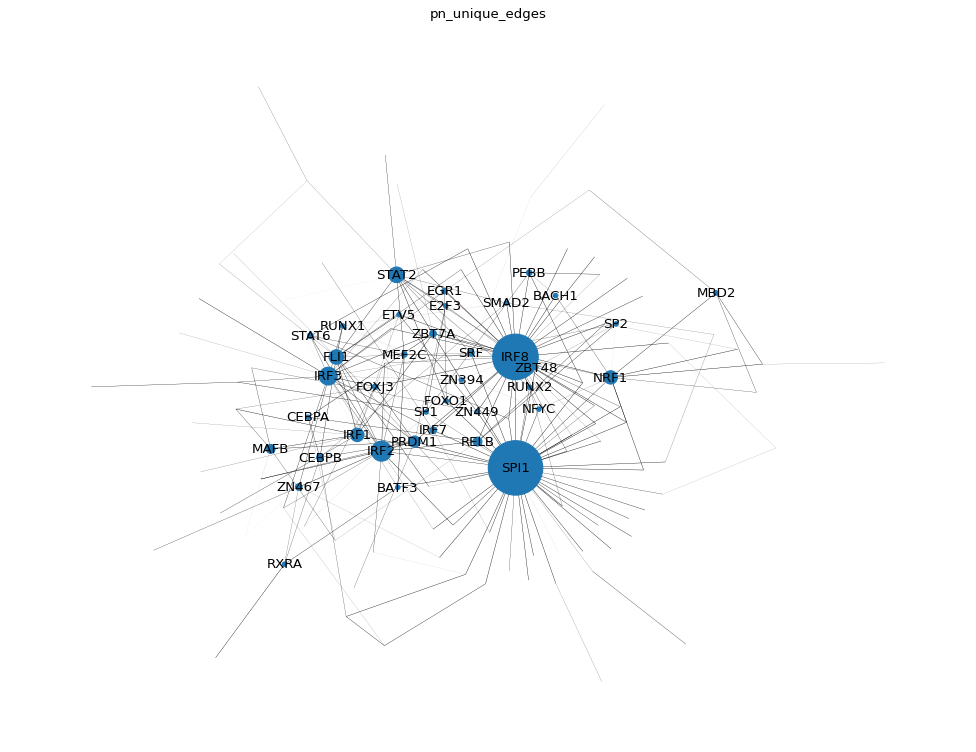

In [15]:
plt.figure(figsize=(12, 9), dpi=80)
G_pn_unq=nx.from_edgelist(pn_unique_pairs)
edges = G_pn_unq.edges()
weights = [ 2* (100-plist_pn[tfpairs.index(tuple(sorted((list(tfnames).index(u),list(tfnames).index(v)))))]) /100  for u,v in edges ]
weights_log= [((weight - 0.01 ) / (0-0.01)) /3 for weight in weights]
G_pn_unq=nx.from_edgelist(pn_unique_pairs)
pos_pn_unq = nx.nx_agraph.pygraphviz_layout(G_pn_unq)
d = dict(G_pn_unq.degree)
label_dict={}
for k,v in zip(G_pn_unq.nodes,G_pn_unq.nodes):
    if d[v]>3:  # only show labels for node degree >3
        label_dict[k]=v
    else:
        label_dict[k]=""
nx.draw(G_pn_unq,pos=pos_pn_unq,with_labels=False, node_size=[v*v if v>3 else 0 for v in d.values() ],width=weights_log )
nx.draw_networkx_labels(G_pn_unq,pos_pn_unq,label_dict)

plt.title("pn_unique_edges")
plt.show()

#### demo to highlight selected TFs, pn

In [16]:
tfs_to_highlight_pn=['SPI1', 'IRF8', 'RUNX2']

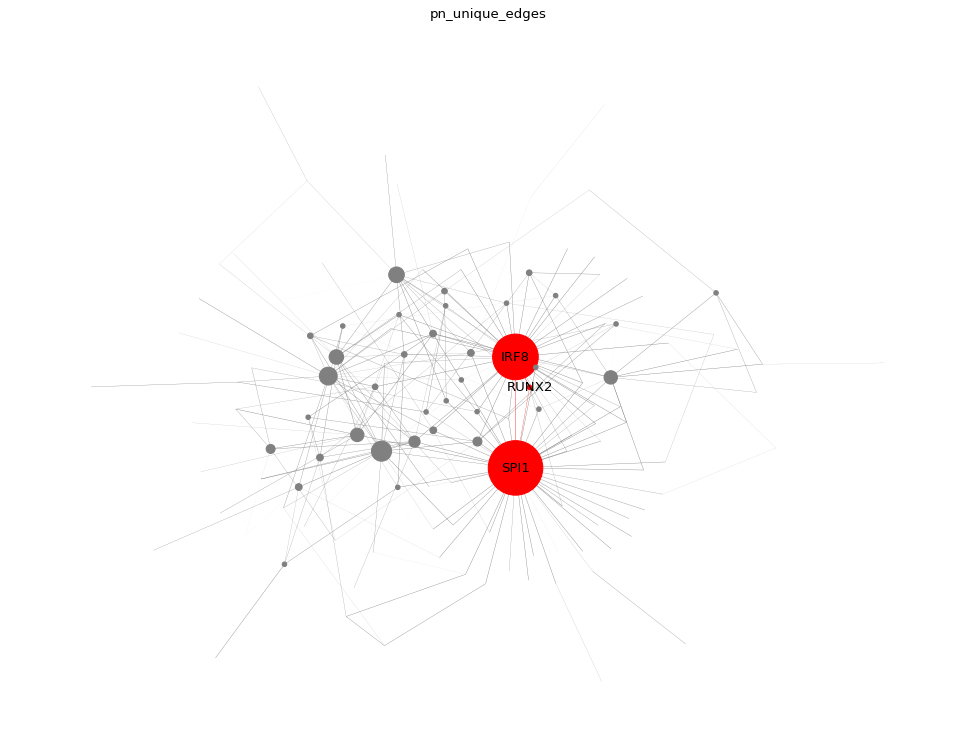

In [17]:
color_map = ['red' if node in tfs_to_highlight_pn else 'grey' for node in G_pn_unq]        
plt.figure(figsize=(12, 9), dpi=80)
edges = G_pn_unq.edges()
weights = [ 2* (100-plist_pn[tfpairs.index(tuple(sorted((list(tfnames).index(u),list(tfnames).index(v)))))]) /100  for u,v in edges ]
weights_log= [((weight - 0.01 ) / (0-0.01)) /3 for weight in weights]
G_pn_unq=nx.from_edgelist(pn_unique_pairs)
edge_colors = ["red" if (u in tfs_to_highlight_pn) & (v in tfs_to_highlight_pn) else "grey"  for u,v in edges]

d = dict(G_pn_unq.degree)
label_dict={}
for k,v in zip(G_pn_unq.nodes,G_pn_unq.nodes):
    if v in tfs_to_highlight_pn:
        label_dict[k]=v
    else:
        label_dict[k]=""
nx.draw(G_pn_unq,pos=pos_pn_unq,with_labels=False,edge_color=edge_colors,node_color=color_map, node_size=[v*v if v>3 else 0 for v in d.values() ],width=weights_log )
nx.draw_networkx_labels(G_pn_unq,pos_pn_unq,label_dict)

plt.title("pn_unique_edges")
plt.show()